# Logistic regression (binary classification) with MNIST

Let us start with a simple example. We will use logistic regression to recognize if a digit is 0 or not.

We import libraries.

In [100]:
import pandas as pd # data processing, CSV file 
import torch # library for tensor computation

We load the MNIST dataset as we did in the [previous notebook](02-using_MNIST.ipynb). The dataset has already been split into training and test sets, so we load them in separate dataframes.

In [65]:
mnist_train = pd.read_csv('../datasets/mnist_train.csv')
mnist_test = pd.read_csv('../datasets/mnist_test.csv')

Let us count the number of samples in each set.

In [101]:
print(f"Number of training examples: {len(mnist_train)}")
print(f"Number of testing examples: {len(mnist_test)}")

Number of training examples: 60000
Number of testing examples: 10000


Let us recall the structure of the dataset. We have 784 features (28x28 pixels) and 1 label column.

In [102]:
mnist_train

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We create tensors from the dataframes to do operations with them. We call these tensors "raw" because we will preprocess them later.

In [106]:
x_train_raw = torch.tensor(mnist_train.iloc[:, 1:].values, dtype=torch.float32)
x_test_raw = torch.tensor(mnist_test.iloc[:, 1:].values, dtype=torch.float32)

In [107]:
print(f"Shape of x_train: {x_train_raw.shape}")
print(f"Shape of x_test: {x_test_raw.shape}")

Shape of x_train: torch.Size([60000, 784])
Shape of x_test: torch.Size([10000, 784])


A good practice is to normalize the data. We divide the pixel values by 255 to get values between 0 and 1. (Remember: the original pixel values are between 0 and 255.)

In [105]:
x_train = x_train_raw / 255 
x_test = x_test_raw / 255

Let us now define the target tensors. 

In [108]:
y_train_raw = torch.tensor(mnist_train.iloc[:, 0].values, dtype=torch.int64).view(-1, 1)
y_test_raw = torch.tensor(mnist_test.iloc[:, 0].values, dtype=torch.int64).view(-1, 1)

In [109]:
print(f"Shape of y_train: {y_train_raw.shape}")
print(f"Shape of y_test: {y_test_raw.shape}")

Shape of y_train: torch.Size([60000, 1])
Shape of y_test: torch.Size([10000, 1])


Before defining our target, we modify the target tensors in a convenient way. This will be also useful for the next notebook on multi-class classification. The original tensors contain the labels indicating the digit. 

In [119]:
print(f"First digit in the training set: {y_train_raw[0].item()}")
print(f"Second digit in the training set: {y_train_raw[1].item()}")
print(f"Third digit in the training set: {y_train_raw[2].item()}")

First digit in the training set: 5
Second digit in the training set: 0
Third digit in the training set: 4


The labels are just words that we use to identify the digits and they only represent the class where the items in the dataset belong to. The numerical values of the labels are not relevant for the classification task. A way to represent classes numerically is to use *one-hot encoding*.

One-hot encoding works as follows. Assume you have $K$ classes. We can enumerate the classes $\{0,1,2,\dots, K-1\}$. We represent each class as a vector in a $K$ dimensional space. More precisely, each class is a coordinate direction in the $K$ dimensional space. This is implemented as follows: We define the bijection
$$
k \in \{0,1,2,\dots, K-1\} \mapsto \begin{pmatrix} 0 \\ \vdots \\ 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{pmatrix} \in \mathbb{R}^K,
$$
where the $1$ is in the $k$-th position (counting from $0$ to $K-1$).

Let us implement this in Python. We use a matrix trick to do this.

The `torch.eye` function creates an identity matrix.

In [121]:
torch.eye(10)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

The one-hot encoding of $k$ is obtained by simply extracting the $k$-th column (or row) of the identity matrix.

In [122]:
torch.eye(10)[2]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

We reshape the tensor so that it is a column vector. The function `one_hot_encode` also works on many labels at once.

In [124]:
def one_hot_encode(y, num_classes):
  return torch.eye(num_classes)[y].view(y.shape[0], num_classes)

In [125]:
y_train_one_hot = one_hot_encode(y_train_raw, num_classes=10)
y_test_one_hot = one_hot_encode(y_test_raw, num_classes=10)

Let us see some examples.

In [128]:
for i in range(7):
  print(f"Label: {y_train_raw[i,:].item()} | One-hot encoding: {y_train_one_hot[i,:]}")

Label: 5 | One-hot encoding: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
Label: 0 | One-hot encoding: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Label: 4 | One-hot encoding: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
Label: 1 | One-hot encoding: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
Label: 9 | One-hot encoding: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
Label: 2 | One-hot encoding: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
Label: 1 | One-hot encoding: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


For binary classification (recognizing if a digit is 0 or not), we will use the following labels:

- 1 if the digit is 0: ''success'',
- 0 if the digit is not 0: ''failure''.
  
We only need the first component of the one-hot encoding. It is equal to 1 if the digit is 0 and 0 otherwise.

In [129]:
y_train = y_train_one_hot[:,0].view(-1, 1)
y_test = y_test_one_hot[:,0].view(-1, 1)

In [131]:
for i in range(7):
  print(f"Label: {y_train_raw[i,:].item()} | Target: {y_train[i,:].item()}")

Label: 5 | Target: 0.0
Label: 0 | Target: 1.0
Label: 4 | Target: 0.0
Label: 1 | Target: 0.0
Label: 9 | Target: 0.0
Label: 2 | Target: 0.0
Label: 1 | Target: 0.0


We define some variables that help to read the code.

In [132]:
n_training_samples = x_train.shape[0]
n_test_samples = x_test.shape[0]
n_features = x_train.shape[1]
print(f"Number of features: {n_features}")
print(f"Number of training samples: {n_training_samples}")
print(f"Number of test samples: {n_test_samples}")

Number of features: 784
Number of training samples: 60000
Number of test samples: 10000


We recall how binary logistic regression works. We have some data $\{(x_i, y_i)\}_{i=0, \ldots, N-1}$ where $x_i \in \mathbb{R}^{1\times M}$ and $y_i \in \{0, 1\}$. The data are thought as realizations of a random sample $(X_0, Y_0), \ldots, (X_{N-1}, Y_{N-1})$ drawn from a certain distribution. We make the *ansatz* that the conditional probability of $Y$ given $X$ is modeled by the logistic function
$$
\mathbb{P}(Y=1|X=x) \approx \sigma(x w + b)
$$
where $\sigma(t) = 1/(1 + \exp(-t))$ is the logistic function and $w \in \mathbb{R}^{M \times 1}$ and $b \in \mathbb{R}$ are the parameters of the model. We want to find the parameters $w$ and $b$ that minimize the realization of the cross-entropy on the sample (see notes)
$$
L(w, b; \{(x_i,y_i)\}_{i=0,\ldots,N-1}) = -\frac{1}{N}\sum_{i=0}^{N-1} \Big( y_i \log(\sigma(x_i w + b)) + (1-y_i) \log(1-\sigma(x_i w + b)) \Big).
$$

In [133]:
# definition of the sigmoid function
def sigma(t):
  return 1 / (1 + torch.exp(-t))

Let us plot it.

In [134]:
import matplotlib.pyplot as plt

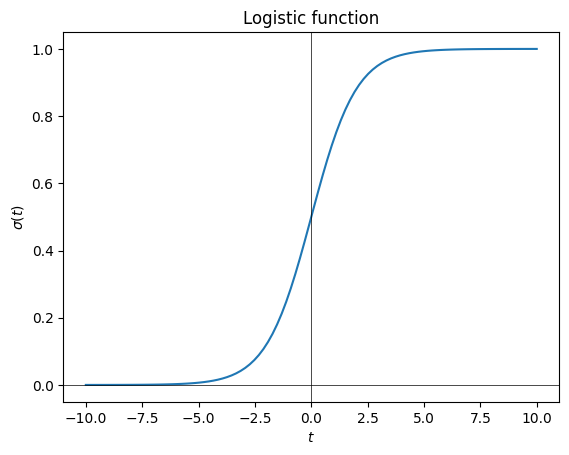

In [135]:
t = torch.linspace(-10, 10, 100)
plt.plot(t.numpy(), sigma(t).numpy())
plt.title('Logistic function')
plt.xlabel(r'$t$')
plt.ylabel(r'$\sigma(t)$')
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.show()


Let us see an example of prediction for a single image done by the model.

In [136]:
x = x_train[0] # pick the first image in the training set

We set random weights and bias.

In [137]:
w = torch.randn(n_features, 1)
b = torch.randn(1)

The prediction is done by applying the logistic function to the dot product of the weights and the image plus the bias.

In [141]:
q = sigma(x @ w + b)

In [144]:
print(q.item())

5.196428446652135e-06


It's a very low value, so the prediction is that the digit is not 0. Of course, there is no meaning in this prediction because the weights and bias are chosen randomly.

We compute the model probability on the whole training set.

In [146]:
q = sigma(x_train @ w + b)
print(f"Shape of q: {q.shape}")

Shape of q: torch.Size([60000, 1])


Computing the cross-entropy loss naively does not work because logarithm of 0 is not defined. 

In [147]:
-torch.mean(y_train * torch.log(q) + (1 - y_train) * torch.log(1 - q))

tensor(nan)

In [148]:
def loss(w,b,x,y):
  y_train_1_bool = (y == 1)
  y_train_0_bool = ~y_train_1_bool
  q = sigma(x @ w + b)
  q_not_0_bool = (q != 0)
  q_not_1_bool = (q != 1)
  return - torch.sum(torch.log(q)[q_not_0_bool*y_train_1_bool]) - torch.sum(torch.log(1-q)[q_not_1_bool*y_train_0_bool]) 

In [149]:
loss(w,b,x_train,y_train)

tensor(136256.5781)

Finding the minimum of the loss is not feasible explicitly. We need to use an optimization algorithm. In the next lectures we will see how to do this. For now, think of the algorithm as a black box.

In [151]:
# ignore this cell, we will understand this later

def gradient_loss(w,b,x,y):
  q = sigma(x @ w + b)
  # Compute gradients
  gradL_dw = x.t() @ (q-y)
  gradL_db = torch.sum(q - y_train)
  
  # Norm clipping gradients
  norm = torch.sqrt(torch.sum(gradL_dw**2 + gradL_db**2))
  scaling_factor = max(1, norm)
  gradL_dw = gradL_dw / scaling_factor
  gradL_db = gradL_db / scaling_factor 
  
  return gradL_dw, gradL_db

def update(w,b,x,y,learning_rate):
  gradL_dw, gradL_db = gradient_loss(w,b,x,y)
  w = w - learning_rate * gradL_dw
  b = b - learning_rate * gradL_db
  return w, b

In the next cell the optimization algorithm is implemented. We will understand what it does in the next lectures. For now, just notice that:
- The algorithm is iterative. It runs for a certain number of iterations: `n_epochs`.
- The algorithm starts from an initial guess of the weights $w$ (random) and bias $b$ (0): `w = torch.randn((n_features, 1), dtype=torch.float32)` and `b = torch.tensor(0,dtype=torch.float32)`.
- In each epoch, we update the values of $w$ and $b$. 
- Every 100 epochs, we keep track of the loss and print it. Later, we will plot it.

In [152]:
learning_rate = 0.1
n_epochs = 1000
torch.manual_seed(42) # this fixes the random seed for the random number generator
w = torch.randn((n_features,1), dtype=torch.float32)
b = torch.tensor(0, dtype=torch.float32)
losses = []
for epoch in range(n_epochs):
  if epoch % 100 == 0:
    losses.append(loss(w,b,x_train,y_train).item())
    print('Epoch:', epoch, ' | Loss:', losses[-1])
  w, b = update(w, b, x_train, y_train, learning_rate)

Epoch: 0  | Loss: 92062.1171875
Epoch: 100  | Loss: 17247.111328125
Epoch: 200  | Loss: 7777.79931640625
Epoch: 300  | Loss: 5192.681640625
Epoch: 400  | Loss: 4180.4765625
Epoch: 500  | Loss: 3609.7021484375
Epoch: 600  | Loss: 3212.296142578125
Epoch: 700  | Loss: 2906.168212890625
Epoch: 800  | Loss: 2657.572265625
Epoch: 900  | Loss: 2449.3544921875


Let us plot how the loss behaves with the number of epochs. 

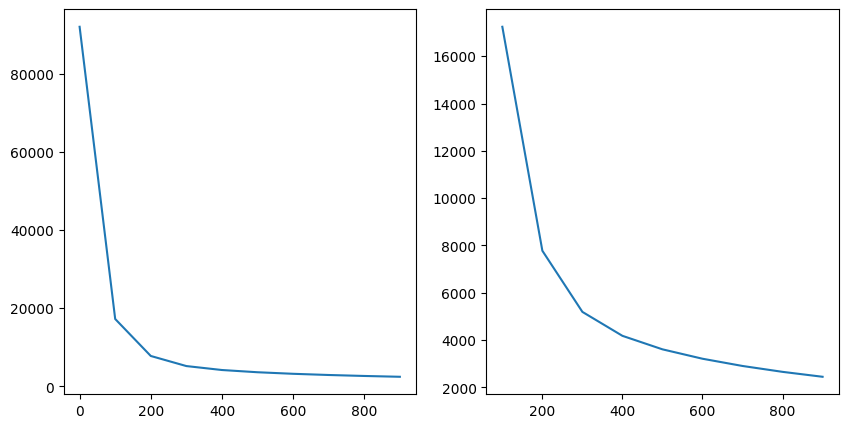

In [153]:
# plot of the loss
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1 = plt.plot(range(0, n_epochs, 100), losses)
ax2 = fig.add_subplot(1, 2, 2)
ax2 = plt.plot(range(0, n_epochs, 100)[1:], losses[1:])

We clearly see that the loss decreases with the number of epochs. This is a good sign. It means that the model is learning and we are getting better values for the weights and bias. After this training phase, we have good values for the weights and bias and we can use them to make predictions on the test set.

To do a prediction, we decide as follows: If the model probability is greater than $50\%$, we predict that the digit is $0$. Otherwise, we predict that the digit is not $0$.

In [154]:
q = sigma(x_test @ w + b) 
y_pred = (q > 0.5).float()

Let us count the percentage of correct predictions.

In [155]:
p_correct_predictions = (torch.sum(y_test == y_pred)/ n_test_samples).item()
print(f'Correct predictions: {p_correct_predictions*100:.4f}%')

Correct predictions: 98.9700%


It's a good result, but don't forget that we are only recognizing if a digit is $0$ or not! If we trivially predict that the digit is not $0$, we get $90\%$ accuracy. Still, it's an improvement over the trivial prediction.

In [157]:
p_trivial_predictions = (torch.sum(y_test == torch.zeros_like(y_test)) / n_test_samples).item()
print(f'Trivial prediction (always trying to predict 0): {p_trivial_predictions*100:.4f}%')

Trivial prediction (always trying to predict 0): 90.2000%


Let us plot some examples of correct and incorrect predictions.

In [164]:
correct_predictions = (y_test == y_pred).view(-1)
wrong_predictions = (y_test != y_pred).view(-1)

x_test_correct = x_test[correct_predictions, :]
y_test_correct = y_test[correct_predictions, :]
y_pred_correct = y_pred[correct_predictions, :]

x_test_wrong = x_test[wrong_predictions, :]
y_test_wrong = y_test[wrong_predictions, :]
y_pred_wrong = y_pred[wrong_predictions, :]

Let us see some examples of correct predictions. (Remember: `1` means that the digit is "$0$" and `0` means that the digit is not "$0$".)

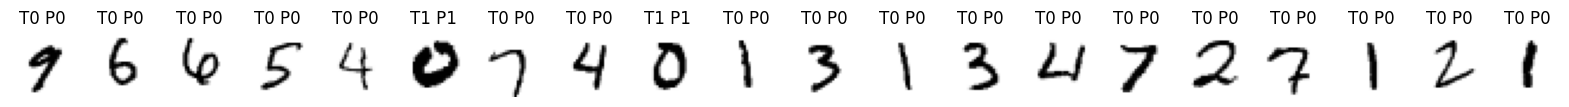

In [166]:
# plot of the wrong predictions
n_example = 20 
fig = plt.figure(figsize=(n_example, 1))
axs = []
offset = 20
for i in range(n_example):
  axs.append(fig.add_subplot(1, n_example, i+1))
  axs[i].imshow(x_test_correct[offset+i,:].view(28,28), cmap='gray_r')
  axs[i].set_title(f'T{y_test_correct[offset+i,0].item():.0f} P{y_pred_correct[offset+i,0].item():.0f}')
  axs[i].axis('off')

Let us see some examples of wrong predictions. (Remember: `1` means that the digit is "$0$" and `0` means that the digit is not "$0$".)

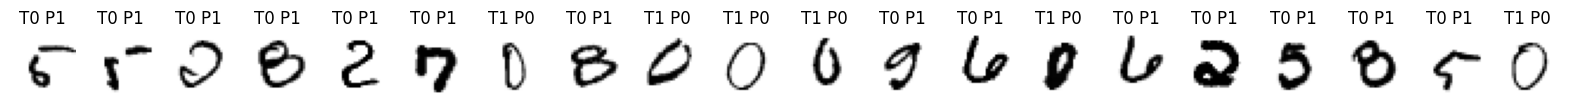

In [167]:
# plot of the wrong predictions
n_example = 20 
fig = plt.figure(figsize=(n_example, 1))
axs = []
offset = 20
for i in range(n_example):
  axs.append(fig.add_subplot(1, n_example, i+1))
  axs[i].imshow(x_test_wrong[offset+i,:].view(28,28), cmap='gray_r')
  axs[i].set_title(f'T{y_test_wrong[offset+i,0].item():.0f} P{y_pred_wrong[offset+i,0].item():.0f}')
  axs[i].axis('off')